## Import and data loader

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def load_polar(file):
    lidar = np.load(file)
    lidar = from_polar(preprocess(lidar).astype('float32'))
    
    length,_,_,_ = lidar.size()
    lidar = lidar.numpy()
    for n in range(length):
        for c in range(3):
            x = lidar[n,c,:,:]
            lidar[n,c,:,:] = np.interp(x, (x.min(), x.max()), (-1, 1))
    return torch.Tensor(lidar)
    #float32 should be used, but reducing for rapid prototyping

def load_CAD120(activity='having_meal'):
    data_path = 'data/Subject1_rgbd_images/%s/'%activity
    train_dataset = ImageFolder(
        root=data_path,
        transform=ToTensor()
    )
    return train_dataset



## Visualize

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

dataset = load_CAD120()
im = dataset[0][0]
print(dataset)
print(np.shape(im))
for i in range(3):
    plt.imshow(im[i,:,:], cmap=cm.gray)
    #plt.gcf().set_size_inches(16,16)
    plt.show()
im = im.transpose(0,2).transpose(0,1)
plt.imshow(im)
#plt.gcf().set_size_inches(16,16)
plt.show()

del dataset
del im

Dataset ImageFolder
    Number of datapoints: 499
    Root location: data/Subject1_rgbd_images/having_meal/
    StandardTransform
Transform: ToTensor()
torch.Size([3, 480, 640])


## VAE process and loss

In [3]:
class VAE_encode(nn.Module):
    def __init__(self, batch_size): #specify parameter functions to train 
        super(VAE_encode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] 2(creates many layers)
        #layer 2, to [10, 128, 10, 64]  2(pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  2(pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (3,4)(further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (2,16)(compression [do we want this?])
        
        #instantiate [10, 3, 480, 640]
        #[10,3,120,160] / 4x4
        #[10, 64,  60, 80] /2
        #[10, 256,  30, 40] /2
        #[10, 256,  15, 20] /2
        #[10, 512,  5, 20] / 3,2, #15,20 if I choose to compress before hand 
        #15,20 if 
        #23, 32
        
        
        #ENCODER1
        nc=3
        ndf=64
        nz = 200
        encode1_layers = []
        encode1_layers += [nn.Conv2d(nc,ndf, 8,4, 2, bias=False)]
        encode1_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode1_layers += [nn.Conv2d(ndf,ndf*2, 4, 2, 1, bias=False)]
        self.encoder1 = nn.Sequential(*encode1_layers)
        
        #ENCODER2
        encode2_layers = []
        encode2_layers += [nn.BatchNorm2d(ndf*2)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf*2,ndf*4, 4,2, 1, bias=False)] 
        
        encode2_layers += [nn.BatchNorm2d(ndf*4)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)]
        
        encode2_layers += [nn.BatchNorm2d(ndf*8)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 8,nz*2, (15,20),1, 0, bias=False)]
        self.encoder2 = nn.Sequential(*encode2_layers)  
        
        self.findmu  = nn.Linear(nz,nz)
        self.findvar = nn.Linear(nz,nz)
    
    def forward(self, x, batch_size, training): #full vae forward path
        #print('encoding to amrr')
        x_amrr = self.encoder1(x)
        mu,logvar = torch.chunk(self.encoder2(x_amrr),2,dim=1)
        #n,c,h,w = mu.size()
        #mu = self.findmu(mu.view(n,-1)).unsqueeze(-1).unsqueeze(-1)
        #logvar = self.findvar(logvar.view(n,-1)).unsqueeze(-1).unsqueeze(-1)
        #print('reparameterizing')
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if training==1:
            z = eps.mul(std).add_(mu)
        else:
            z = mu
        return z, mu, logvar 


class VAE_decode(nn.Module):
    def __init__(self, batch_size): #specify parameter functions to train 
        super(VAE_decode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] (creates many layers)
        #layer 2, to [10, 128, 10, 64]  (pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  (pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (compression [do we want this?])
                #uses 4 not 2
        #DECODER
        nz = 200 
        ngf = 64 
        nc = 3
        decode_layers = []
        decode_layers += [nn.ConvTranspose2d(nz,ngf*8,(15,20),1,0,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*8)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 8, ngf * 4,4,2,1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*4)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 4, ngf * 2,4, 2, 1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*2)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 2, ngf * 1,4, 2, 1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*1)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf, nc,8, 4, 2,bias=False)]
        decode_layers += [nn.ReLU(True)]
        self.decoder = nn.Sequential(*decode_layers)
        
    
    def forward(self, z, batch_size): #full vae forward path
        #print('decoding')
        x_pred = self.decoder(z)
        #print('decode size',x_pred.size())
        return x_pred
        
def KLloss(mu, logvar):
    return torch.sum(-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=-1))

def MSEloss(sample, data):
    l,c,h,w = sample.size()
    x = sample.view(l,c,-1).transpose(0,1)
    y = data.view(l,c,-1).transpose(0,1)
    
    #sum of mean square errors for each channel
    a = torch.sum(torch.sum((x[0]-y[0])**2,dim=-1))
    b = torch.sum(torch.sum((x[1]-y[1])**2,dim=-1))
    c = torch.sum(torch.sum((x[2]-y[2])**2,dim=-1))
    #print('a: %.2f, b: %.2f, c: %.2f'%(a,b,c))
    mse_loss = a+b+c
    
    ''' 
    a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    weight=torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_x = F.conv2d(sample, weight)
    data_x  = F.conv2d(data, weight)
    
    b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    weight=torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_y = F.conv2d(sample, weight)
    data_y  = F.conv2d(data, weight)

    sample_grad=torch.sqrt(torch.pow(sample_x,2)+ torch.pow(sample_y,2))
    data_grad=torch.sqrt(torch.pow(data_x,2)+ torch.pow(data_y,2))
    
    edge_loss = F.mse_loss(sample_grad,data_grad)
    '''
    return mse_loss
        
    
    

## Training

loading data
 


EPOCH : 0




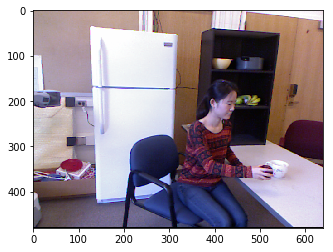

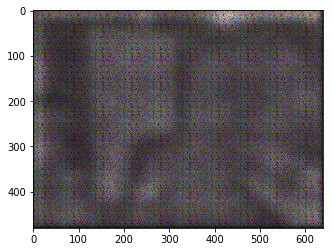



EPOCH : 1




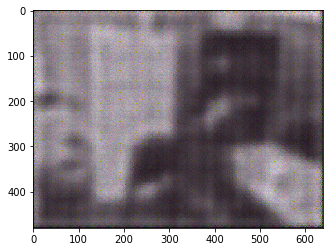



EPOCH : 2




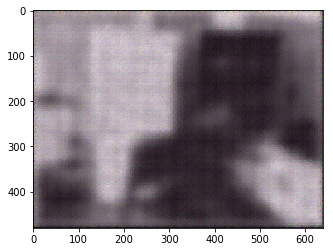



EPOCH : 3




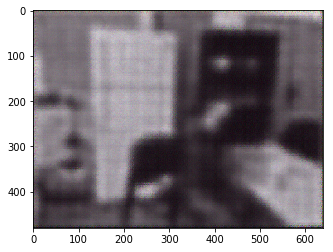



EPOCH : 4




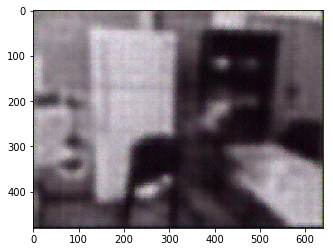



EPOCH : 5




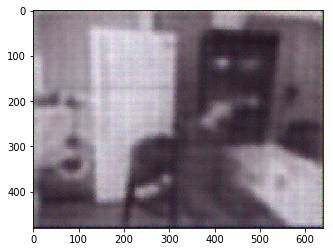



EPOCH : 6




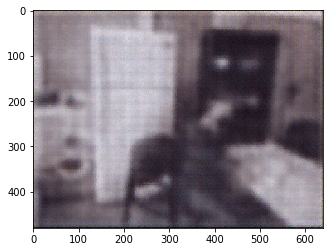



EPOCH : 7




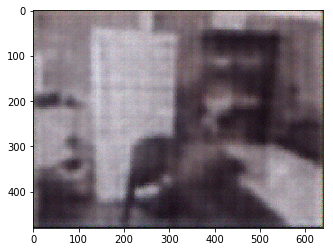



EPOCH : 8




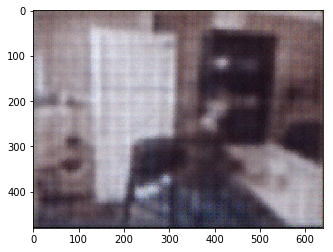



EPOCH : 9




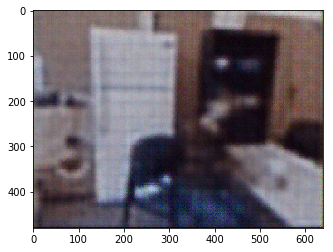



EPOCH : 10




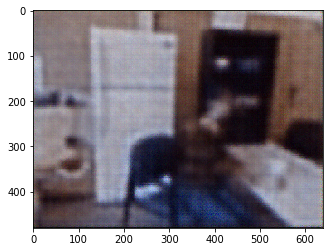



EPOCH : 11




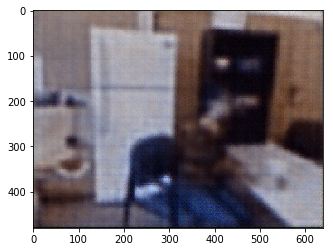



EPOCH : 12




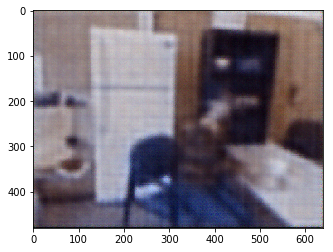



EPOCH : 13




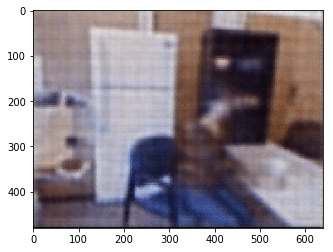



EPOCH : 14




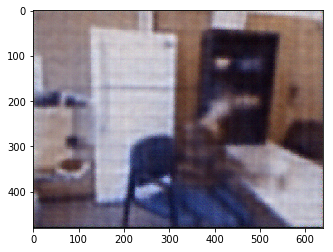



EPOCH : 15




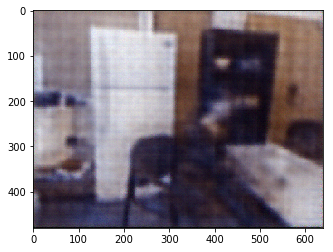



EPOCH : 16




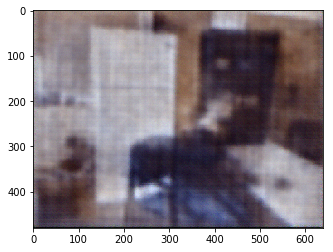



EPOCH : 17




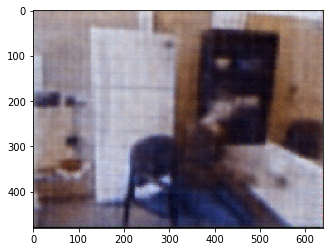



EPOCH : 18




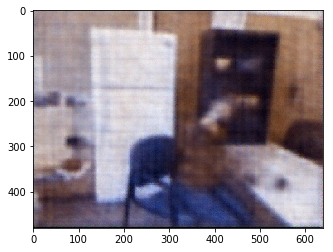



EPOCH : 19




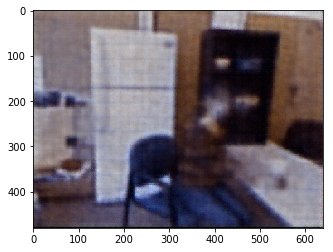

In [73]:
print('loading data')
names = ['lidar_val.npz','lidar_val.npz']
#val length: 152

#1728
batch_size=10 #10 feasible, 20 waaaaay too slow
loader = DataLoader(load_CAD120()
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
print(' ')


#the vae trains the convolution layers
network_encode = VAE_encode(batch_size)
network_decode = VAE_decode(batch_size)
lr = 0.00005 #this should prevent the over
solver_encode = optim.Adam(network_encode.parameters(), lr=lr/2)#/2)
solver_decode = optim.Adam(network_decode.parameters(), lr=lr*5)
#network.eval() #changes batch normalization behavior

encoder_loss = []
decoder_loss = []
encoder_test = []
decoder_test = []

data_set = []
pred_set = []
mu_set = []
logvar_set = []

epochs = 20
for epoch in range(epochs):
    print('\n\nEPOCH : %d\n\n'%epoch)
    batchcount = 0
    for batch in loader: 
        ## ENCODE STEP
        batch = batch[0]
        
        #print('encoding')
        solver_encode.zero_grad()
        z, mu, logvar = network_encode(batch, batch_size, training=1)
        #print('encode step')
        loss1 = KLloss(mu,logvar)
        loss1.backward(retain_graph=True)
        solver_encode.step()
        
        ## DECODE STEP
        #print('decoding')
        solver_decode.zero_grad()
        pred = network_decode(z, batch_size)
        #print('decoding step')
        loss2 = MSEloss(pred, batch)
        loss2.backward()
        solver_decode.step()
        batchcount+=1
        #print('batchcount ',batchcount)
        
        if batchcount==40:
            encoder_loss.append(loss1.detach())
            decoder_loss.append(loss2.detach())
        if batchcount>40:
            encoder_test.append(loss1.detach())
            decoder_test.append(loss2.detach()) 
            break
        #if epoch==(epochs-1):
            #data_set.append(batch)
            #pred_set.append(pred)
            #mu_set.append(mu)
            #logvar_set.append(logvar)
        
    
    #Print image comparisons 

    if epoch==0:
        im = batch[0].detach().numpy()
        im = np.transpose(im, (1, 2, 0))
        plt.imshow(im)
        plt.show()
    
    im = pred[0].detach().numpy()
    im = np.clip(im,0,2)/im.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.show()


## Plot

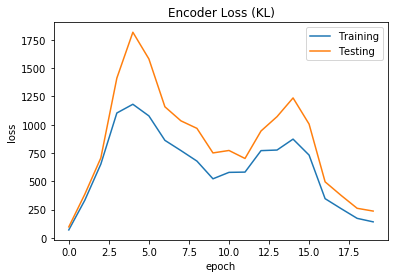

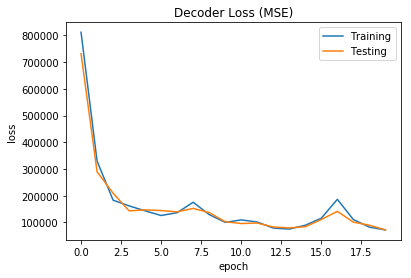

In [74]:
#Save Data
np.save('data_set',np.array(data_set)) 
np.save('pred_set',np.array(pred_set))
np.save('mu_set',np.array(mu_set)) 
np.save('logvar_set',np.array(logvar_set))
torch.save(network_encode.state_dict(), 'encoder_save')
torch.save(network_decode.state_dict(), 'decoder_save')

#Print
encoder_loss = np.array(encoder_loss)
decoder_loss = np.array(decoder_loss)
encoder_test = np.array(encoder_test)
decoder_test = np.array(decoder_test)


plt.plot(range(len(encoder_loss)),encoder_loss, label="Training")
plt.plot(range(len(encoder_test)),encoder_test, label="Testing")
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim((0,100))
plt.title('Encoder Loss (KL)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')

plt.plot(range(len(decoder_loss)),decoder_loss, label="Training")
plt.plot(range(len(decoder_test)),decoder_test, label="Testing")
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim((0,1))
plt.title('Decoder Loss (MSE)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')

## Vid Function 

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate(dataset):
    dataset = np.transpose(dataset,(0,2,3,1))
    dataset = np.clip(dataset,0,2)/dataset.max()
    
    fig = plt.figure()
    ims = []
    for i in range(len(dataset)):
        im = plt.imshow(dataset[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    # ani.save('dynamic_images.mp4')
    #plt.show()


## Corruption Test!

loading data
 
(3, 480, 640)


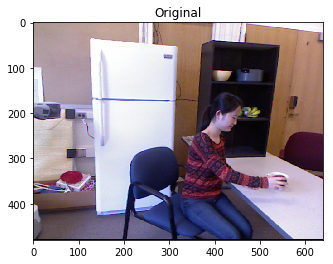

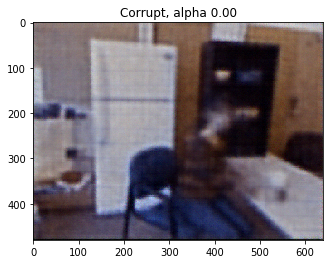

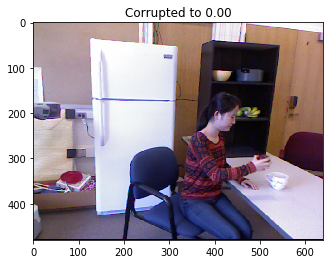

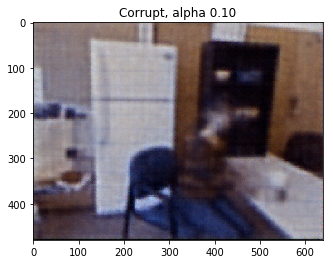

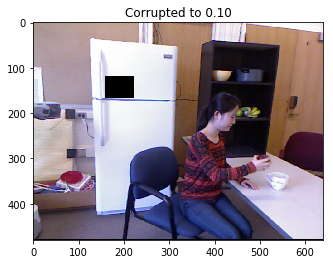

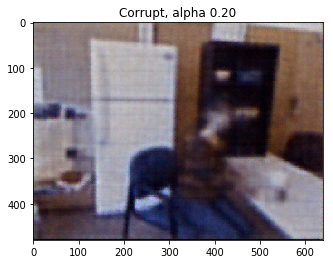

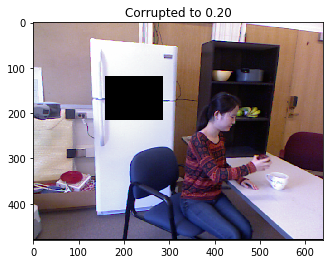

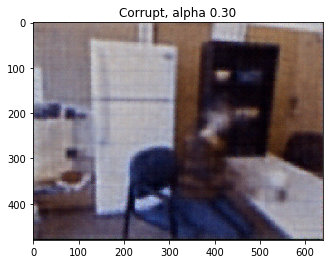

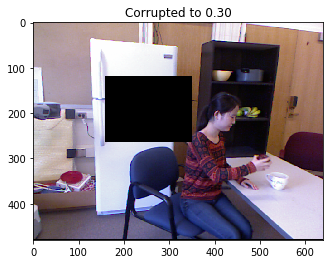

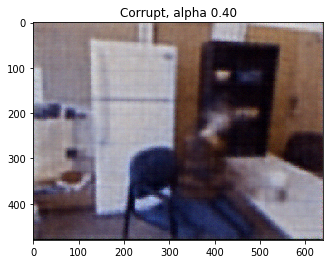

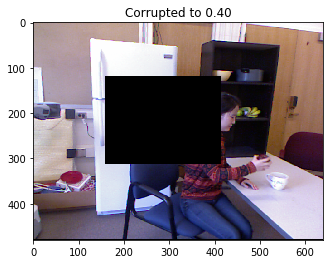

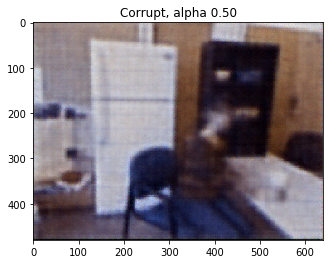

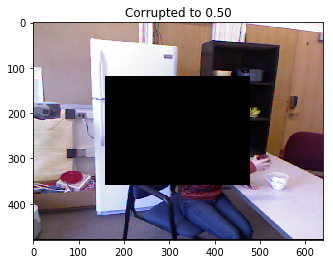

In [108]:
def corrupt(batch, alpha_spatial=0.1, alpha_temporal=0.1):
    n,c,h,w = batch.size()
    #print(batch.size())
    #spatial corruption
    k = h*w*alpha_spatial
    pk = k / (h*w)
    vec = np.random.choice([0,1],size=(h*w,),p=[pk,1-pk])
    vec = np.reshape(vec,(h,w))
    vec = np.tile(vec,(n,c,1,1))
    vec = torch.Tensor(vec)
    corrupt = batch * vec
    
    vec = np.ones((n,c,h,w))
    vec[0,:,int(h/4):int(h/4)+int(alpha_spatial*h),int(w/4):int(w/4)+int(alpha_spatial*w)] = 0
    vec = torch.Tensor(vec)
    corrupt = batch * vec
    
    #temporal corruption 
    k = n*alpha_temporal
    pk = k / n
    vec = np.random.choice([0,1],size=(n,),p=[pk,1-pk])
    #apply 
    for i in range(len(vec)):
        corrupt[i] *= vec[i]  
    return corrupt

print('loading data')
batch_size = 10
loader = DataLoader(load_CAD120()
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
print(' ')

#network encode and decode are saved

#the vae trains the convolution layers
network_encode = VAE_encode(batch_size)
network_encode.load_state_dict(torch.load('encoder_save'))
network_decode = VAE_decode(batch_size)
network_decode.load_state_dict(torch.load('decoder_save'))

encoder_ideal = []
decoder_ideal = []
encoder_corrupt = []
decoder_corrupt = []



alpha_temporal = 0.0
alpha_spatial_list = [0.0, 0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,.2]
alpha_spatial_list = [0.0, .1,.2,.3,.4,.5]

for i, alpha_spatial in enumerate(alpha_spatial_list):
    batchcount = 0
    encoder_ideal_temp = []
    decoder_ideal_temp = []
    encoder_corrupt_temp = []
    decoder_corrupt_temp = []
    
    for batch in loader: 
        batch = batch[0]
        if batchcount>=3:
            #testbatch=batch
            break
    
        z, mu, logvar = network_encode(batch, batch_size, training=0)
        loss1 = KLloss(mu,logvar)
        pred = network_decode(z, batch_size)
        loss2 = MSEloss(pred, batch)
        encoder_ideal_temp.append(loss1.detach())
        decoder_ideal_temp.append(loss2.detach())

        corrbatch = corrupt(batch, alpha_spatial=alpha_spatial, alpha_temporal=alpha_temporal)
        z, mu, logvar = network_encode(corrbatch, batch_size, training=0)
        loss1 = KLloss(mu,logvar)
        predcorr = network_decode(z, batch_size)
        loss2 = MSEloss(predcorr, batch)
        encoder_corrupt_temp.append(loss1.detach())
        decoder_corrupt_temp.append(loss2.detach())

        batchcount+=1
        
    encoder_ideal.append(np.mean(encoder_ideal_temp))
    decoder_ideal.append(np.mean(decoder_ideal_temp))
    encoder_corrupt.append(np.mean(encoder_corrupt_temp))
    decoder_corrupt.append(np.mean(decoder_corrupt_temp))

    #Print image comparisons 
    '''
    if i==0:
        dataset = batch.detach().numpy()
        print("Original Data")
        animate(dataset)
        
    if 1==1:
        dataset = corrbatch.detach().numpy()
        print("Corrupted Data")
        animate(dataset)
        
    dataset = predcorr.detach().numpy()
    print("Corrupted Reconstruction, alpha=%.2f"%alpha_spatial)
    animate(dataset) 
    '''
    
    if i==0:
        im = batch[0].detach().numpy()
        print(np.shape(im))
        im = np.transpose(im, (1, 2, 0))
        plt.imshow(im)
        plt.title('Original')
        plt.show()

    im = predcorr[0].detach().numpy()
    im = np.clip(im,0,2)/im.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Corrupt, alpha %.2f'%alpha_spatial)
    plt.show()

    if 1==1:#i==(len(alpha_temporal_list)-1):
        im = corrbatch[0].detach().numpy()
        im = np.transpose(im, (1, 2, 0))
        plt.imshow(im)
        plt.title('Corrupted to %.2f'%alpha_spatial_list[i])
        plt.show()


## Plot Corruption

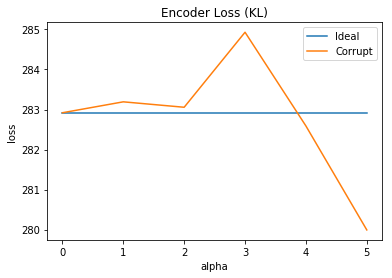

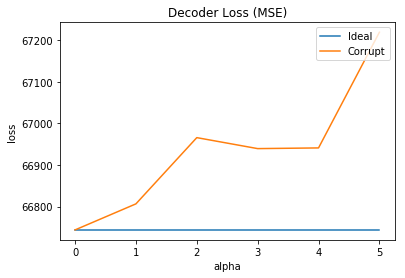

In [109]:

#Print
encoder_loss = np.array(encoder_ideal)
decoder_loss = np.array(decoder_ideal)
encoder_test = np.array(encoder_corrupt)
decoder_test = np.array(decoder_corrupt)


plt.plot(range(len(encoder_loss)),encoder_loss, label="Ideal")
plt.plot(range(len(encoder_test)),encoder_test, label="Corrupt")
plt.xlabel('alpha')
plt.ylabel('loss')
#plt.ylim((0,100))
plt.title('Encoder Loss (KL)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')

plt.plot(range(len(decoder_loss)),decoder_loss, label="Ideal")
plt.plot(range(len(decoder_test)),decoder_test, label="Corrupt")
plt.xlabel('alpha')
plt.ylabel('loss')
#plt.ylim((0,1))
plt.title('Decoder Loss (MSE)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')